# Ex 2 - Transfer learning
##### Group: X
###### Student 1: Diego Fraile
###### Student 2:
###### Student 3:

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from sklearn.metrics import accuracy_score

## Load the Dataset and visualize it

In [2]:
# Download and split the food101 dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    "food101",
    split=["train", "validation[:50%]", "validation[50%:]"],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteNCZJKJ/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteNCZJKJ/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
# Filter the dataset to keep the first 20 classes only.
N_CLASSES = 20
CLASS_NAMES = info.features['label'].names[:N_CLASSES]

train_ds = train_ds.filter(lambda img, label: label < N_CLASSES)
validation_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)
test_ds = test_ds.filter(lambda img, label: label < N_CLASSES)

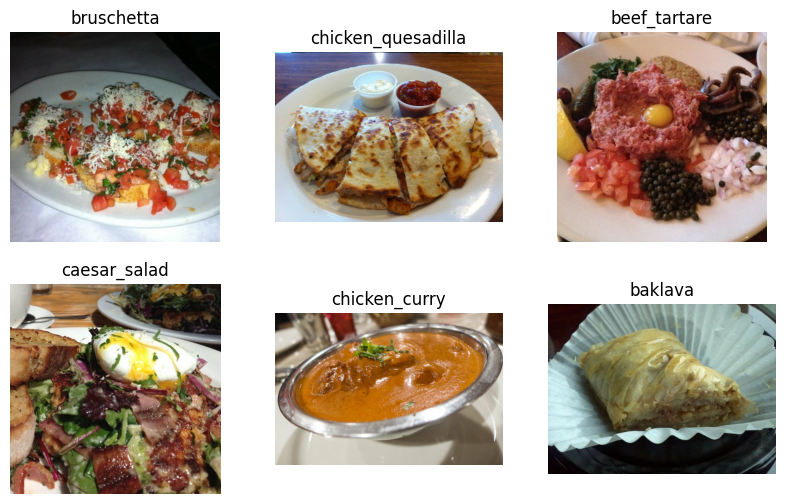

In [5]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

## Resize and normalize

In [6]:
# Resize the images in the training, validation and test set
IMG_SIZE = 224
train_ds = train_ds.map(lambda img, label: (tf.image.resize(img, (IMG_SIZE, IMG_SIZE)), label))
validation_ds = validation_ds.map(lambda img, label: (tf.image.resize(img, (IMG_SIZE, IMG_SIZE)), label))
test_ds = test_ds.map(lambda img, label: (tf.image.resize(img, (IMG_SIZE, IMG_SIZE)), label))

In [7]:
# Normalize the images
train_ds = train_ds.map(lambda img, label: (img / 255, label))
validation_ds = validation_ds.map(lambda img, label: (img / 255, label))
test_ds = test_ds.map(lambda img, label: (img / 255, label))

In [8]:
# One hot encode the labels
train_ds = train_ds.map(lambda img, label: (img, tf.one_hot(label, N_CLASSES)))
validation_ds = validation_ds.map(lambda img, label: (img, tf.one_hot(label, N_CLASSES)))
test_ds = test_ds.map(lambda img, label: (img, tf.one_hot(label, N_CLASSES)))

In [9]:
BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE)
validation_ds = validation_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

## Data-Augmentation

In [ ]:
# Optional define/implements data-augmentation

## Training
### Step 1: Only train the head of the network

In [16]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models.
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours.
# A model like mobilenet is more than enough for the exercise.

# Use MobileNetV22 as the base model
base_model = keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base_model
base_model.trainable = False

# Create the model structure
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(N_CLASSES, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 20)                2580      
                                                                 
Total params: 2424532 (9.25 MB)
Trainable params: 166548 (6

In [17]:
%%time

# Compile the model with your optimizer, your loss and your metrics
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

# Optional: Define and use callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

step1_history = model.fit(train_ds, epochs=5, validation_data=validation_ds, callbacks=callbacks)

Epoch 1/5
469/469 [==============================] - 112s 233ms/step - loss: 1.4352 - categorical_accuracy: 0.5644 - val_loss: 1.1103 - val_categorical_accuracy: 0.6547
Epoch 2/5
469/469 [==============================] - 110s 235ms/step - loss: 0.9748 - categorical_accuracy: 0.6997 - val_loss: 1.0664 - val_categorical_accuracy: 0.6647
Epoch 3/5
469/469 [==============================] - 103s 219ms/step - loss: 0.8093 - categorical_accuracy: 0.7525 - val_loss: 1.0600 - val_categorical_accuracy: 0.6714
Epoch 4/5
469/469 [==============================] - 110s 235ms/step - loss: 0.6815 - categorical_accuracy: 0.7944 - val_loss: 1.0780 - val_categorical_accuracy: 0.6762
Epoch 5/5
469/469 [==============================] - 105s 224ms/step - loss: 0.5756 - categorical_accuracy: 0.8295 - val_loss: 1.1172 - val_categorical_accuracy: 0.6754
CPU times: user 14min 29s, sys: 32.1 s, total: 15min 1s
Wall time: 10min 48s


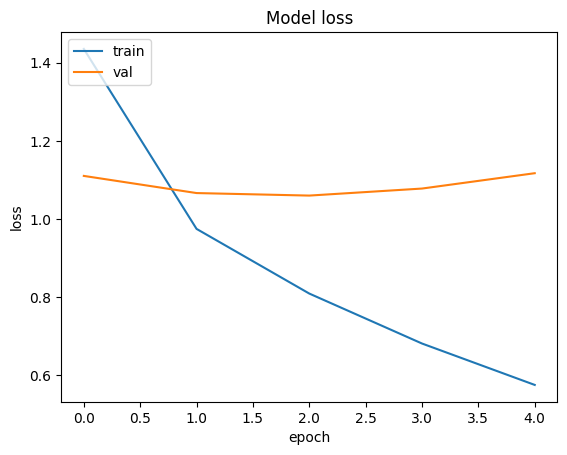

In [18]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_history(step1_history, 'loss')

### Step 2: Fine-Tune the whole model

In [19]:
%%time


# Unfreeze the pretrained base.

base_model.trainable = True


# Compile the model again
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)


# Retrain the model
step2_history = model.fit(train_ds, epochs=5, validation_data=validation_ds, callbacks=callbacks)

Epoch 1/5
469/469 [==============================] - 153s 269ms/step - loss: 0.4740 - categorical_accuracy: 0.8540 - val_loss: 1.0096 - val_categorical_accuracy: 0.7092
Epoch 2/5
469/469 [==============================] - 123s 262ms/step - loss: 0.3331 - categorical_accuracy: 0.9055 - val_loss: 1.0368 - val_categorical_accuracy: 0.7088
Epoch 3/5
469/469 [==============================] - 129s 275ms/step - loss: 0.2403 - categorical_accuracy: 0.9414 - val_loss: 1.0627 - val_categorical_accuracy: 0.7116
Epoch 4/5
469/469 [==============================] - 129s 274ms/step - loss: 0.1738 - categorical_accuracy: 0.9659 - val_loss: 1.0931 - val_categorical_accuracy: 0.7136
Epoch 5/5
469/469 [==============================] - 134s 285ms/step - loss: 0.1253 - categorical_accuracy: 0.9811 - val_loss: 1.0779 - val_categorical_accuracy: 0.7204
CPU times: user 17min 32s, sys: 33.1 s, total: 18min 5s
Wall time: 11min 8s


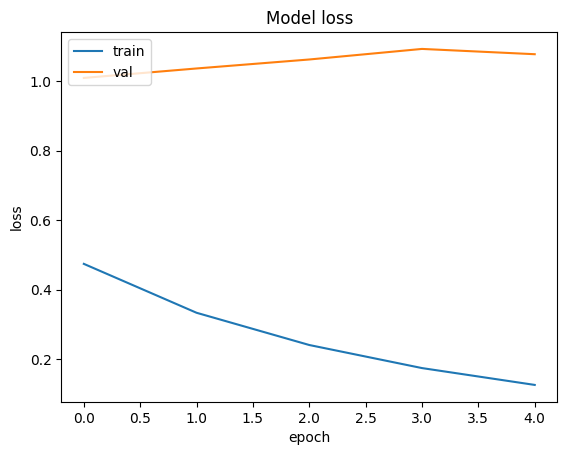

In [20]:
plot_history(step2_history, 'loss')

## Test the fine-tuned model

In [ ]:
%%time
# Predict the test set
y_pred = model.predict(test_ds, verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

     25/Unknown - 7s 219ms/step

In [ ]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

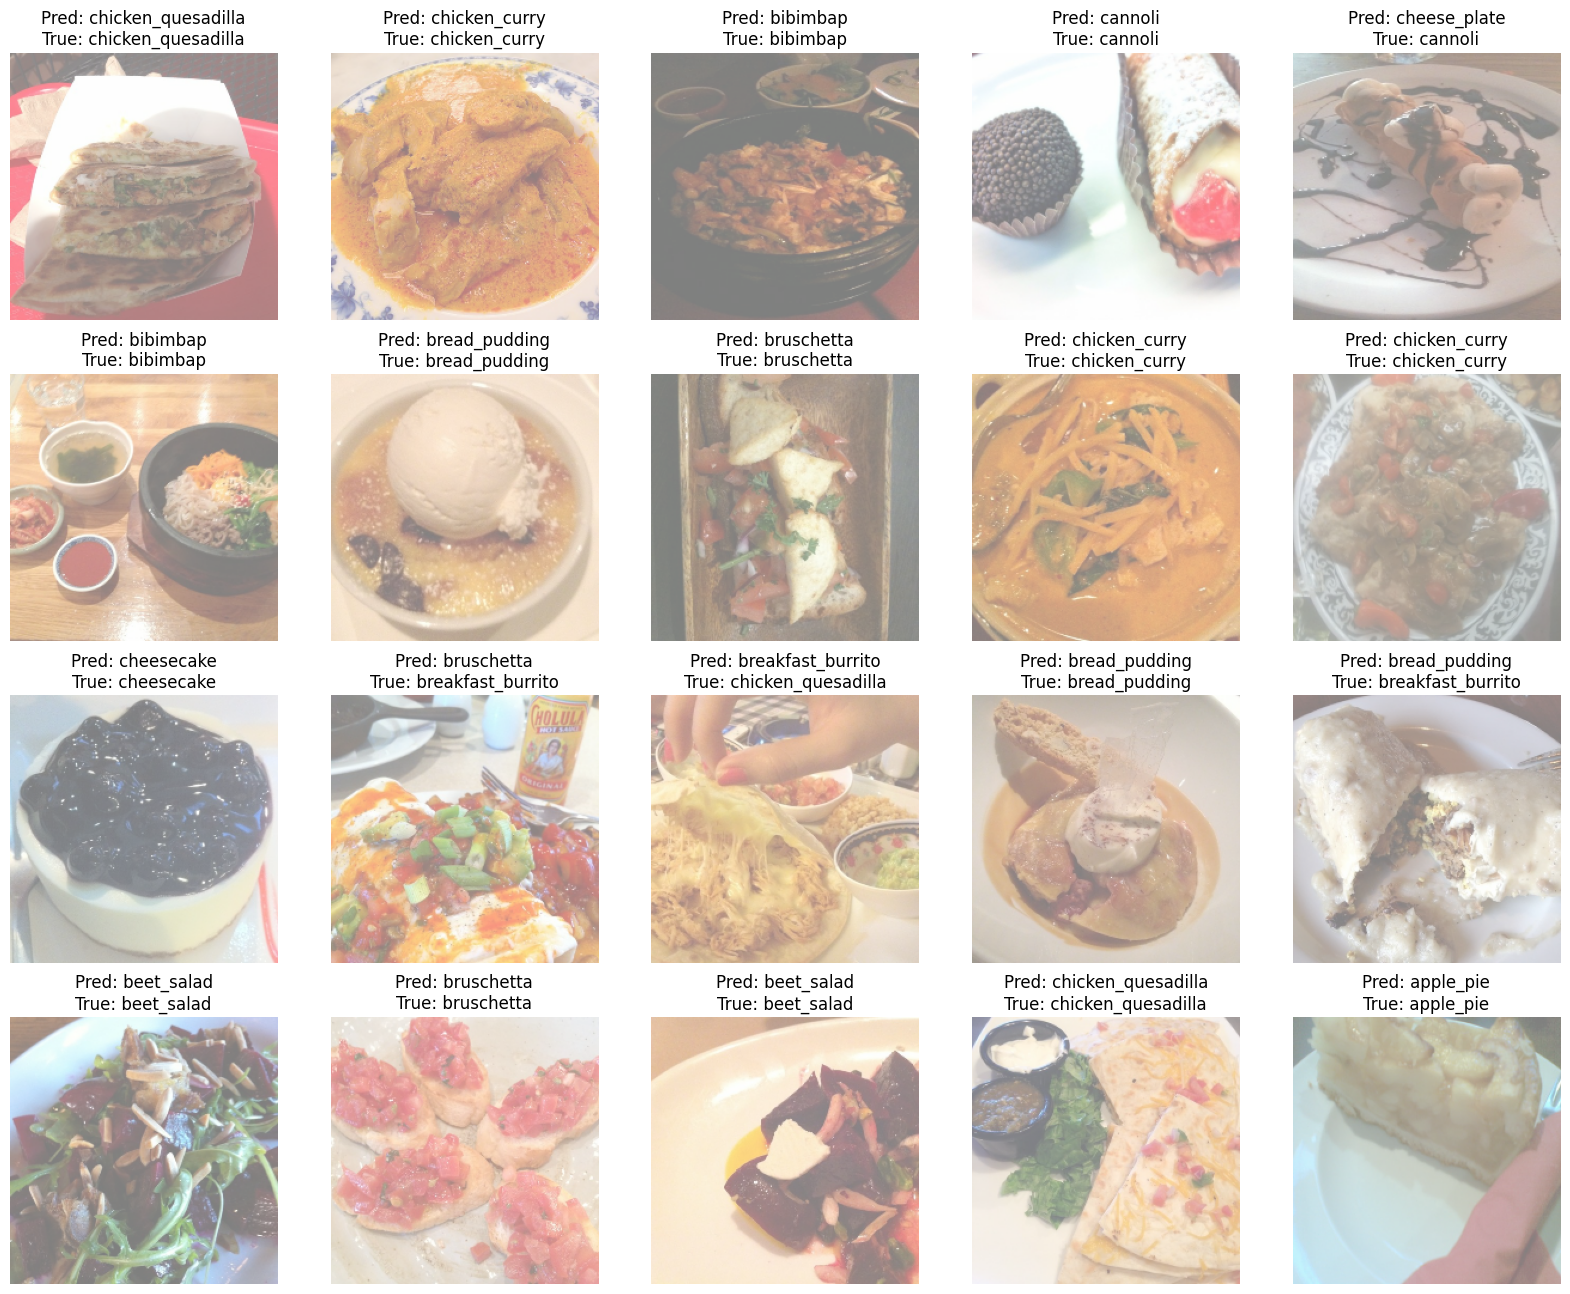

In [23]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds])+1)/2*255
    test_examples = test_examples.astype("uint32")

    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)